In [71]:
import getdata
import numpy as np 
import network
import matplotlib.pyplot as plt
import scipy.ndimage
import pickle
import cv2
import os
from keras.models import model_from_json, Model
from keras.losses import mean_squared_error as loss
from keras import backend as K

In [60]:
# load data
flatten = False      # Get 1D data
rescale = True       #  Rescale 'RGB' values from [0,255] to [1,0]
denoise_only = False # Reshape target values from 128x128 to 64x64
amount = 1000        # Amount of data to load, 0 gives loads all data
train_x, train_y = getdata.get_training(flatten = flatten, rescale = rescale, amount = amount, denoise_only = denoise_only)
test_data, rng = getdata.get_test(flatten = flatten, rescale = rescale, denoise_only = denoise_only, amount = amount if amount < 4000 else 3999) 

1000


In [43]:
# Load Model

model_name = 'hugenet2'

# model reconstruction from JSON
net = network.Network(None, None, None, test = 0)
with open(os.getcwd() + '/model_weights/'+ model_name +'_architecture.json', 'r') as f:
    net.network = model_from_json(f.read())
# load weights into the model
net.network.load_weights(os.getcwd() + '/model_weights/'+ model_name +'_weights.h5')

net.network.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   832         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   25632       conv2d_1[0][0]                   
__________________________________________________________________________________________________
add_1 (Add)                     (None, 64, 64, 32)   0           conv2d_2[0][0]                   
                                                                 input_1[0][0]                    
__________

In [61]:
# Compute Errors
y_true = K.variable(train_y)
predictions = net.predict(train_x)
y_pred = K.variable(predictions)
error = np.expand_dims(K.eval(loss(y_true, y_pred)), axis=3)
mean_error = np.squeeze(np.mean(error,(1,2)))

In [72]:
ind = np.argpartition(mean_error, -10)[-10:]

with open('error_indices.pkl', 'wb') as output:
    pickle.dump(ind, output, pickle.HIGHEST_PROTOCOL)

In [ ]:
amount = 5


inputs > outputs > target > error


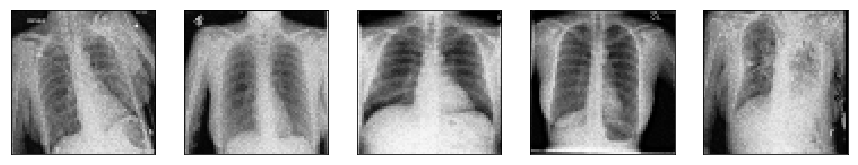

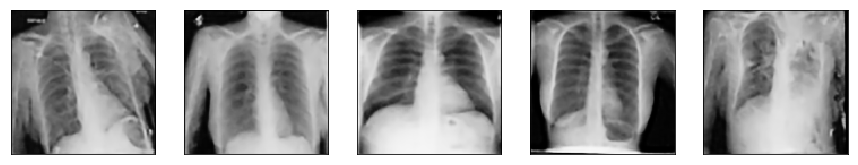

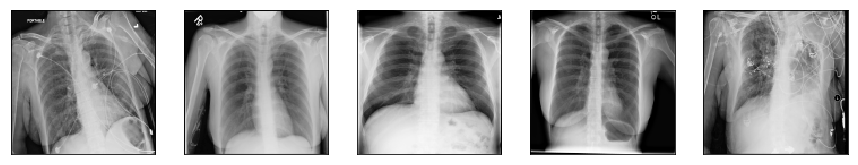

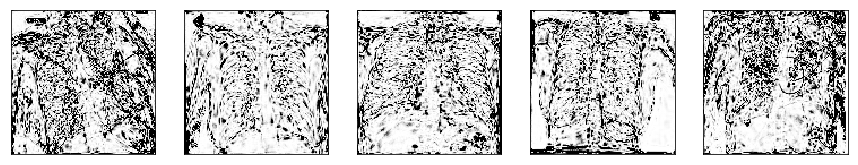

In [68]:
amount = 5
indexes = np.argpartition(mean_error, -amount)[-amount:]

# show heatmap of images with the most error
print('inputs > outputs > target > error')
plotrow(train_x, indexes)
plotrow(predictions, indexes)
plotrow(train_y, indexes)
plotrow(error, indexes, 0, 0.001)

In [38]:
def plotrow(img_array, indexes, vmin = 0, vmax = 1):
    amount_ = len(indexes)
    plt.figure(figsize=(3*amount_, 6))
    for n,i in enumerate(indexes):
        ax = plt.subplot(2, amount_, n + 1)
        plt.imshow(np.squeeze(img_array[i],2), cmap = 'Greys', vmin = vmin, vmax = vmax)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()